In [4]:
import numpy as np
import scipy.interpolate
import torch
import xarray as xr
import pandas as pd 
import tqdm

from dantro.plot.utils import ColorManager

import include as base
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import LAND, BORDERS
import networkx as nx
import pandas as pd 
from pyproj import Transformer

In [5]:
import numpy as np
import scipy
from scipy.interpolate import splrep, BSpline, UnivariateSpline

In [6]:
from matplotlib import rcParams
from cycler import cycler
colors = {
    
    'c_darkblue': '#2F7194',
    'c_red': '#ec7070',
    'c_darkgreen': '#48675A',
    'c_lightblue': '#97c3d0',
    'c_lightgreen': '#AFD8BC',
    'c_lightbrown': '#C6BFA2',
    'c_orange': '#EC9F7E',
    'c_yellow': '#F5DDA9',
    'c_darkgrey': '#3D4244',
    'c_pink': '#F8A6A6',
    'c_purple': '#A07CB0',
    'c_lightgrey': '#AFC1B9',
}
rcParams['axes.prop_cycle'] = cycler(color=list(colors.values()))
fs=9
rcParams.update(**{
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amssymb} \usepackage{amsmath}",
    "font.size": fs, 
    "axes.titlesize": fs,
    "axes.labelsize": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "grid.linewidth": 0.5,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})

In [7]:
# Import all the code conversion tables
code_to_iso3 = (pd.read_csv("/Users/thomasgaskin/UN_migration_data/Iso_code_lookup.csv")[["Numeric", "Alpha-3 code"]]).set_index("Numeric")
code_to_iso3 = code_to_iso3[~code_to_iso3.index.isna()]
code_to_iso3.index = code_to_iso3.index.astype(int)
code_to_iso3 = code_to_iso3.to_dict()['Alpha-3 code']
iso3_to_name = pd.read_csv("/Users/thomasgaskin/UN_migration_data/Iso_code_lookup.csv").set_index('Alpha-3 code')['Country'].to_dict()
iso2_to_3 = (pd.read_csv("/Users/thomasgaskin/UN_migration_data/Iso_code_lookup.csv")[["Alpha-2 code", "Alpha-3 code"]]).set_index("Alpha-2 code").to_dict()['Alpha-3 code']

In [8]:
# Import UN migration data
UN_data = pd.read_csv("/Users/thomasgaskin/UN_migration_data/UN_data.csv", low_memory=False, index_col=0).drop(["Notes", "Location code", "SDMX code**", "Parent code", "ISO2 Alpha-code"], axis=1).set_index(["Variant", "Year", "ISO3 Alpha-code"])
UN_data = UN_data[UN_data.Type == "Country/Area"].to_xarray().squeeze(drop=True)
UN_data = UN_data.assign_coords({"Year": UN_data.coords["Year"].data.astype(int)}).rename({'ISO3 Alpha-code': 'country', 'Year': 'year'})

# Drop the Holy See (all NAN)
UN_data = UN_data.drop_sel({"country": "VAT"})

# Convert the strings to floats
for var in UN_data.data_vars:
    try:
        UN_data[var].data = np.reshape([float(s.replace(' ', '')) for s in UN_data[var].data.flatten()], UN_data[var].shape)
    except:
        continue

In [225]:
# Import the UN Stock data and adjust
stock_data = pd.read_csv("/Users/thomasgaskin/UN_migration_data/UN_stock_data/Table 1-Table 1.csv", low_memory=False, index_col=0)
stock_data.drop(["1990.1", "1995.1", "2000.1", "2005.1", "2010.1", "2015.1", "2020.1", 
                 "1990.2", "1995.2", "2000.2", "2005.2", "2010.2", "2015.2", "2020.2", 
                 "Notes of destination", "Type of data of destination"], axis=1, inplace=True)
stock_data['Origin ISO'] = [code_to_iso3.get(x, None) for x in stock_data['Location code of origin']]
stock_data['Destination ISO'] = [code_to_iso3.get(x, None) for x in stock_data['Location code of destination']]

rows_to_drop = []

# Drop flows that are not between countries
for idx, row in stock_data.iterrows():
    if row['Origin ISO'] is None or row['Destination ISO'] is None:
        rows_to_drop.append(idx)
stock_data.drop(rows_to_drop, axis=0, inplace=True)
print(f'Dropped {len(rows_to_drop)} rows')

# Reshape and convert to numbers
stock_data.rename({'Location code of origin': 'Origin Numeric', 
                   'Location code of destination': 'Destination Numeric',
                   'Region, development group, country or area of destination': 'Destination', 
                   'Region, development group, country or area of origin': 'Origin'}, axis=1, inplace=True)
def replace(_s):
    if _s == "0..":
        return np.nan 
    else:
        return(int(_s.replace(' ', '')))
for col in ["1990", "1995", "2000", "2005", "2010", "2015", "2020"]:
    stock_data[col] = [replace(s) for s in stock_data[col]]

# Make the year a coordinate
l = []
for year in ["1990", "1995", "2000", "2005", "2010", "2015", "2020"]:
    data_year = stock_data[["Origin ISO", "Destination ISO", year]].copy()
    data_year["Year"] = int(year)
    data_year.rename({year: "Stock"}, axis=1, inplace=True)
    l.append(data_year)

# Reshape and convert to xarray
stock_data = pd.concat(l, axis=0).set_index(["Origin ISO", "Destination ISO", "Year"])
stock_data_xr = stock_data.to_xarray()['Stock']

# Drop the Holy See, since there is no inflow 
stock_data_xr = stock_data_xr.drop_sel({"Origin ISO": "VAT"})

Dropped 25100 rows


In [264]:
# Define the interpolation function
def interpolate(_x, _y):
    
    _x_interp = np.arange(_x[0], _x[-1]+1, 1, dtype=int)
    
    # Single point: no derivative
    if len(_x) == 1:
        return np.array([_x.data[0]]), np.array([_y.data[0]]), np.array([np.nan])
    
    # Two points: linear interpolation (may not be consecutive)
    elif len(_x) == 2:
        return _x_interp, np.array([_y.data[0] + i * (_y.data[1] - _y.data[0]) / (len(_x_interp)-1) for i in range(len(_x_interp))]), len(_x_interp) * [(_y.data[1] - _y.data[0])/(len(_x_interp)-1)]
    
    else:
        _spl = scipy.interpolate.PchipInterpolator(_x.data, _y.data, extrapolate=True)(_x_interp)
        _y_diffs = _y.diff('Year', label='lower') / 5
        _x_diffs = _y_diffs.coords['Year'] + 2.5
        _spl_diff = scipy.interpolate.PchipInterpolator(_x_diffs, _y_diffs.data, extrapolate=True)(_x_interp)
        
        return _x_interp, _spl, _spl_diff

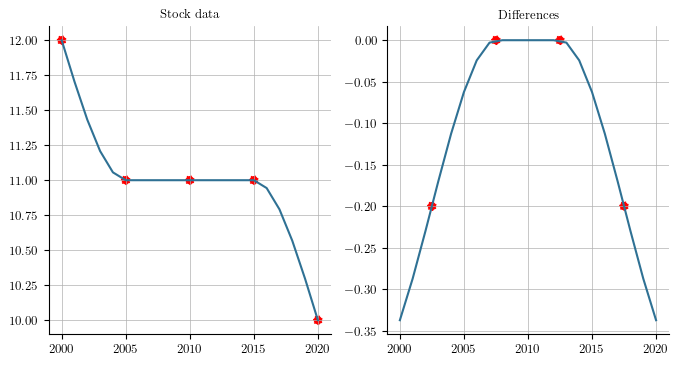

In [265]:
# Plot examples of the interpolation
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

country_pair = ("FIN", "GEO")

# Get the stock data
y = stock_data_xr.sel({"Origin ISO":country_pair[0], "Destination ISO": country_pair[1]}).dropna('Year')
x = y.coords['Year']

# Interpolate the stock data and its derivative
x_interp, y_interp, y_diff_interp = interpolate(x, y)

# Plot the interpolations
axs[0].plot(x_interp, y_interp)
axs[1].plot(x_interp, y_diff_interp)
axs[0].set_title("Stock data")
axs[1].set_title("Differences")

# Also plot the true data
axs[0].scatter(x, y, color='red', linestyle='dotted')
y_diffs = y.diff('Year', label='lower') / 5
axs[1].scatter(y_diffs.coords['Year'].data + 0.5/(len(y.coords['Year'].data)-1) * (y.coords['Year'].data[-1] - y.coords['Year'].data[0]), y_diffs, color='red', linestyle='dotted')

In [269]:
# Populate a table with the interpolated stock estimates and their derivatives
stock = xr.DataArray(
    data = np.nan * np.zeros((31, len(stock_data_xr.coords['Origin ISO'].data), len(stock_data_xr.coords['Destination ISO'].data))),
    dims = ["Year", "Origin ISO", "Destination ISO"], 
    coords={"Year": np.arange(1990, 2021, 1), "Origin ISO": stock_data_xr.coords['Origin ISO'].data,
            "Destination ISO": stock_data_xr.coords['Destination ISO']}
)
stock_deriv=stock.copy()

with tqdm.tqdm(total=len(stock_data_xr.coords['Origin ISO'].data) * len(stock_data_xr.coords['Destination ISO'].data), desc="Interpolating stock data") as pbar:
    for origin in stock_data_xr.coords['Origin ISO'].data:
        for destination in stock_data_xr.coords['Destination ISO'].data:
            pbar.update(1)
            if not all(np.isnan(stock_data_xr.sel({'Origin ISO': origin, 'Destination ISO': destination}).data)):
                _y = stock_data_xr.sel({"Origin ISO": origin, "Destination ISO": destination}).dropna('Year')
                _x = _y.coords['Year']
                
                _x_interp, _s_interp, _s_diff_interp = interpolate(_x, _y)   
                            
                stock.loc[{'Year': _x_interp, 'Destination ISO': destination, 'Origin ISO': origin}] = xr.DataArray(_s_interp, dims=["Year"])
                stock_deriv.loc[{'Year': _x_interp, 'Destination ISO': destination, 'Origin ISO': origin}] = xr.DataArray(_s_diff_interp, dims=["Year"])

Interpolating stock data: 100%|██████████| 52900/52900 [00:14<00:00, 3673.62it/s]


In [312]:
# Get the proportionality constant alpha
NZ_data = pd.read_csv("/Users/thomasgaskin/UN_migration_data/bilat_nzl.csv").drop("country", axis=1)
NZ_data = NZ_data[[isinstance(s, str) for s in NZ_data.iso3c]]
NZ_data["year"] = NZ_data["year"].astype(int)
NZ_data = NZ_data.set_index(["year", "iso3c", "direction"])
NZ_data = NZ_data[~NZ_data.index.duplicated()].to_xarray()
NZ_data = xr.Dataset({"arrivals": NZ_data["flow"].sel({"direction": "arrivals"}, drop=True),
            "departures": NZ_data["flow"].sel({"direction": "departures"}, drop=True)})
alpha = (NZ_data["arrivals"].sel({"iso3c": "AUS", 'year': 2019}) - (max(stock_deriv.sel({"Origin ISO": "AUS", "Destination ISO": "NZL", "Year": 2019}), 0) + max(-stock_deriv.sel({"Origin ISO": "NZL", "Destination ISO": "AUS", "Year": 2019}), 0))) / (stock.sel({"Origin ISO": "AUS", "Destination ISO": "NZL", "Year": 2019}) + stock.sel({"Origin ISO": "NZL", "Destination ISO": "AUS", "Year": 2019}))

In [314]:
# Build the distance metric
distance_metric = xr.DataArray(
    data = np.nan * np.zeros((31, len(UN_data.coords['country'].data), len(UN_data.coords['country'].data))),
    dims = ["Year", "Origin ISO", "Destination ISO"], 
    coords={"Year": np.arange(1990, 2021, 1), 
            "Origin ISO": UN_data.coords['country'].data,
            "Destination ISO": UN_data.coords['country'].data}
)
total_foreign_population = stock.sum("Destination ISO")
with tqdm.tqdm(total=len(stock_data_xr.coords['Origin ISO'].data) * len(stock_data_xr.coords['Destination ISO'].data), desc="Constructing distance metric") as pbar:
    for origin in stock_data_xr.coords['Origin ISO'].data:
        for destination in stock_data_xr.coords['Destination ISO'].data:
            pbar.update(1)
            
            # No flow within countries
            if origin == destination:
                distance_metric.loc[{"Origin ISO": origin, "Destination ISO": destination}] = np.zeros(len(distance_metric.coords["Year"].data))
                continue
            
            # Stock of i in j
            _N_ij = alpha * stock.sel({"Origin ISO": origin, "Destination ISO": destination})
                        
            # Change in flow i -> j (positive part only)
            _dN_ij = np.maximum(stock_deriv.sel({"Origin ISO": origin, "Destination ISO": destination}), 0)

            if destination in stock_deriv.coords["Origin ISO"].data and origin in stock_deriv.coords["Destination ISO"].data:
                
                # Stock of j in i
                _N_ji = alpha * stock.sel({"Origin ISO": destination, "Destination ISO": origin})
                
                # Change in flow j -> (negative part only)
                _dN_ji = np.maximum(-stock_deriv.sel({"Origin ISO": destination, "Destination ISO": origin}), 0)
            
            else:
                _N_ji = np.nan * np.ones_like(_N_ij)
                _dN_ji = np.nan * np.ones_like(_dN_ij)
                
            # Stack the three metrics
            _data = np.stack([_N_ij, _N_ji, _dN_ij, _dN_ji])
            
            # If the data are all NAN for all years, set the edge to 1 
            if all(np.isnan(_data.flatten())):
                distance_metric.loc[{"Origin ISO": origin, "Destination ISO": destination}] = np.ones(len(distance_metric.coords["Year"].data))
            else:
                distance_metric.loc[{"Origin ISO": origin, "Destination ISO": destination}] = np.nansum(_data, axis=0)

Constructing distance metric: 100%|██████████| 52900/52900 [00:49<00:00, 1073.42it/s]


In [339]:
# Set Taiwan as average of HKG and KOR?
distance_metric.loc[{"Origin ISO": "TWN"}] = distance_metric.sel({"Origin ISO": ["KOR", "HKG"]}).mean("Origin ISO")
distance_metric.loc[{"Destination ISO": "TWN"}] = distance_metric.sel({"Destination ISO": ["KOR", "HKG"]}).mean("Destination ISO")

In [349]:
# Read the country coordinates
country_coords = pd.read_csv("/Users/thomasgaskin/UN_migration_data/Coordinates.csv", index_col=2)
country_coords = country_coords[~country_coords.index.duplicated()]
nw = nx.DiGraph()

year = 2005
_data = distance_metric.sel({"Year": year}, drop=True)

# Add the exporters
for country in _data.coords['Origin ISO'].data:
    
    nw.add_node(country, pos=(country_coords.loc[country, 'Latitude'], 
                              country_coords.loc[country, 'Longitude']),
                net_migration=UN_data['Net Number of Migrants (thousands)'].sel({"year": year, "country": country}))

# Add edges
for origin in _data.coords['Origin ISO'].data:
    for dest in _data.coords['Destination ISO'].data:
        if origin == dest:
            continue
        T = _data.sel({"Origin ISO": origin, "Destination ISO": dest})
        if np.isnan(T.data.item()) or T.data.item() == 0:
            continue
        nw.add_edge(origin, dest, weight=T.data.item())

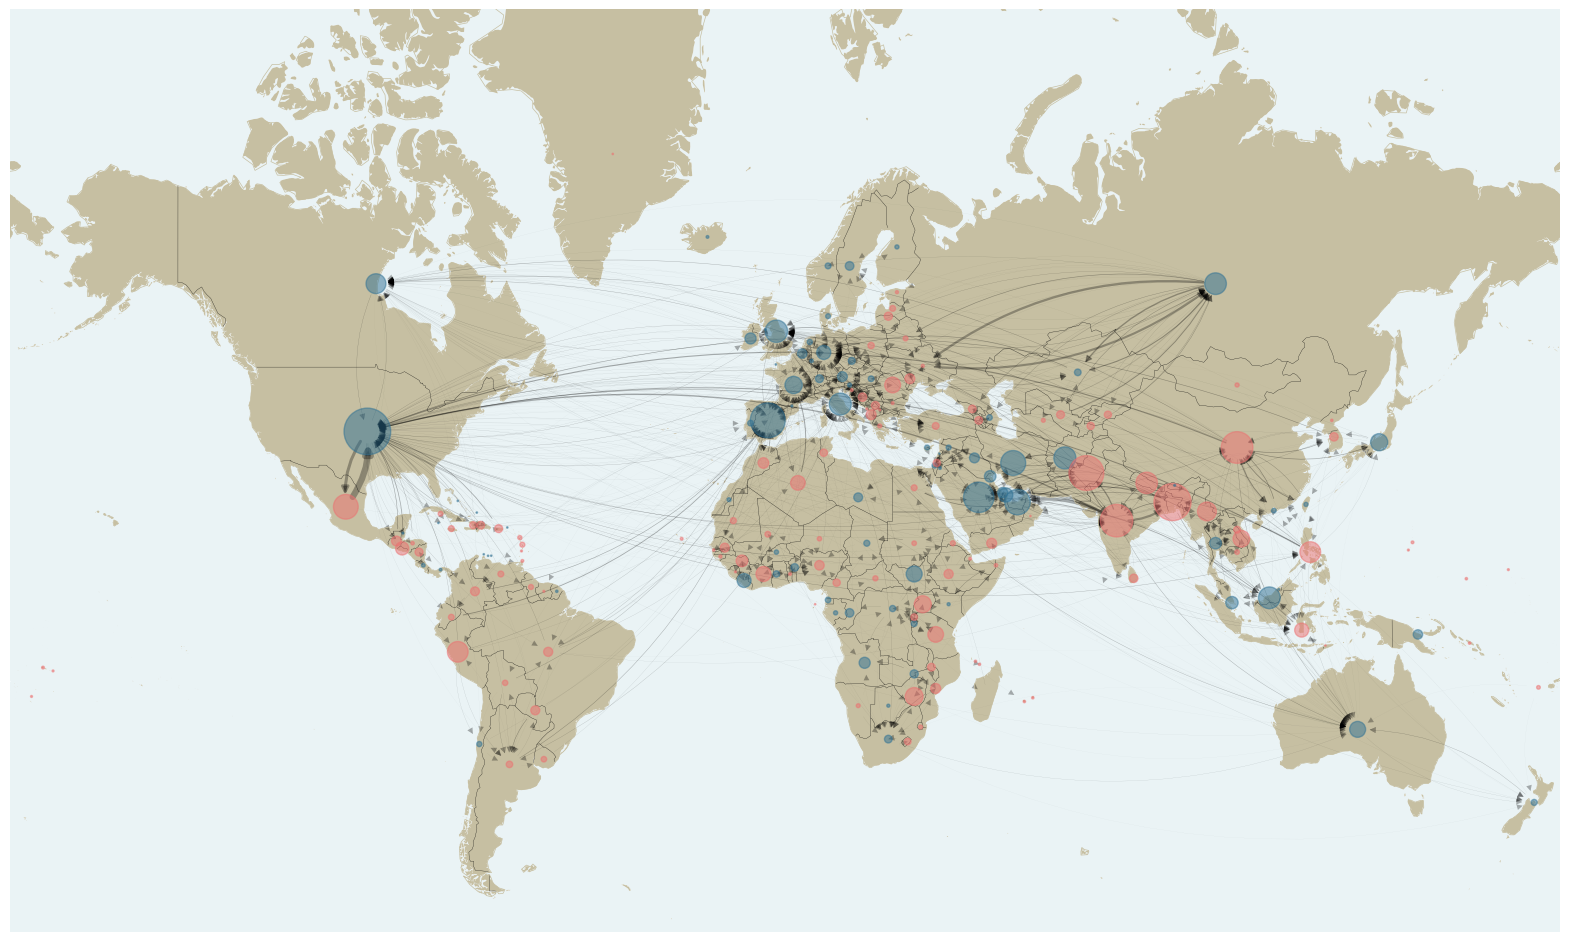

In [350]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(projection=ccrs.Mercator()))
ax.coastlines(color=colors['c_lightbrown'], lw=0.5)
land = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', facecolor=colors['c_lightbrown'])
sea = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=colors['c_lightblue'], alpha=0.2)
ax.axis('off')
ax.set_extent([-180, 180, -60, 80])
ax.add_feature(land, zorder=-2)
ax.add_feature(sea, zorder=-3)
ax.add_feature(BORDERS, lw=0.2, zorder=-1)
 
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Plot the nodes
node_pos = dict((k, transformer.transform(*v)) for k, v in nx.get_node_attributes(nw, 'pos').items())
node_size = dict((k, abs(v)) for k, v in nx.get_node_attributes(nw, 'net_migration').items())
node_colors = [colors['c_red'] if v < 1 else colors['c_darkblue'] for v in nx.get_node_attributes(nw, 'net_migration').values()]
nx.draw_networkx_nodes(nw, node_pos, ax=ax, node_size=list(node_size.values()), node_color=node_colors, alpha=0.5)

# Plot the n largest flows
n = 1000
edges = dict(((u[0], u[1]), u[2]) for u in sorted([(k[0], k[1], v) for k, v in nx.get_edge_attributes(nw, 'weight').items()], key=lambda l: l[-1], reverse=True)[:n])

_ = nx.draw_networkx_edges(nw, node_pos, edges, ax=ax, alpha=0.3, 
                           width=1e-5*np.array(list(edges.values())),
                           connectionstyle='arc3, rad=0.2', arrowsize=10)

In [317]:
estimated_net_migration = distance_metric.sum("Origin ISO").rename({"Destination ISO": "country"}) - distance_metric.sum("Destination ISO").rename({"Origin ISO": "country"})

Text(0.5, 0, 'True value')

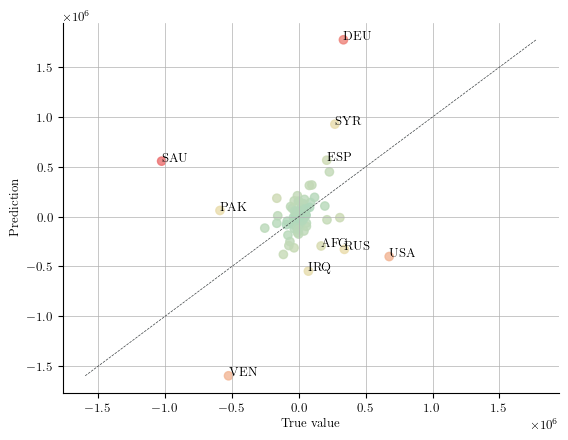

In [348]:
fig, ax = plt.subplots()

indices = np.random.choice(len(estimated_net_migration.coords['Year']), 4, replace=False)

year = 2020
_est = estimated_net_migration.sel({"Year": year})
_true_data = UN_data['Net Number of Migrants (thousands)'].sel({"year": year, "country": _est.coords['country'].data}) * 1000
color_data = abs(_est-_true_data)
cm = ColorManager(
cmap={'from_values': {0: colors['c_lightgreen'], 0.5: colors['c_yellow'], 1: colors['c_red']}, 'continuous': True},
vmin=color_data.min(), vmax=color_data.max())   
ax.scatter(_true_data, _est, c=color_data, cmap=cm.cmap, alpha=0.8)
_min = np.minimum(_est.min(), _true_data.min().item())
_max = np.maximum(_est.max(), _true_data.max().item())
ax.plot(
    [_min, _max], [_min, _max], lw=0.5, color=colors['c_darkgrey'], linestyle='dashed'
)

# Label the 10 largest discrepancies
max_discrepancies = color_data.isel({"country": color_data.argsort().data[-10:]})
for country in max_discrepancies.coords['country'].data:
    ax.text(_true_data.sel({"country": country}), _est.sel({"country": country}), country)
ax.set_ylabel("Prediction")
ax.set_xlabel("True value")

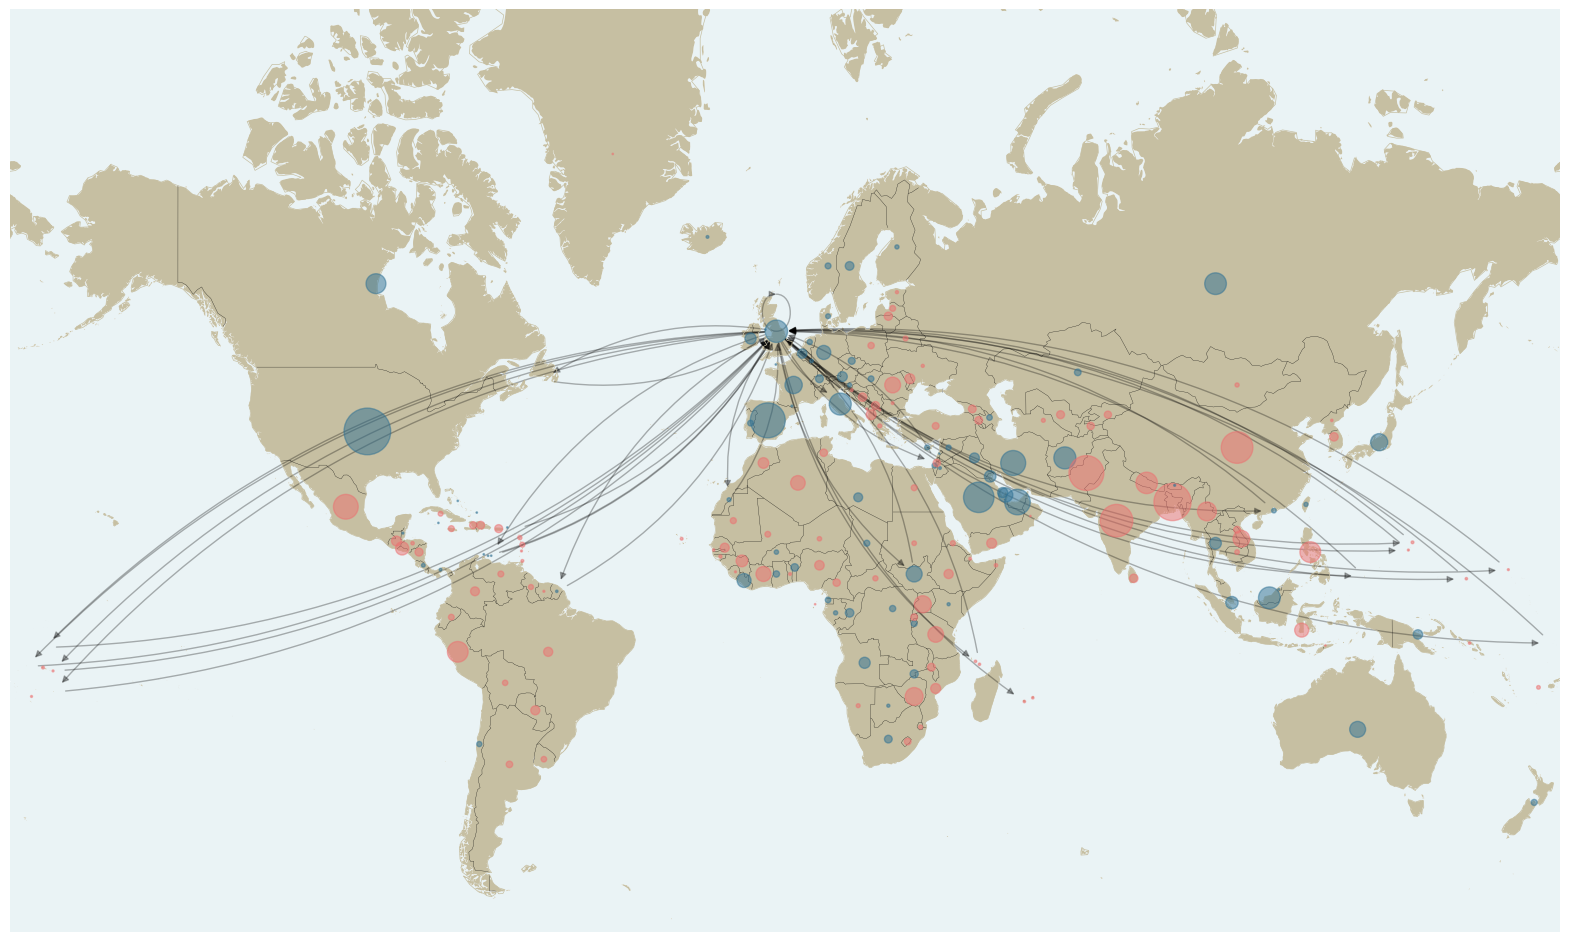

In [387]:
# Plot the missing edges for a given country
nw = nx.DiGraph()

# Add all countries
for country in _data.coords['Origin ISO'].data:
    
    nw.add_node(country, pos=(country_coords.loc[country, 'Latitude'], 
                              country_coords.loc[country, 'Longitude']),
                net_migration=UN_data['Net Number of Migrants (thousands)'].sel({"year": year, "country": country}))

country = "GBR"

# Add edges
for c in distance_metric.coords['Origin ISO'].data:
    if all(distance_metric.sel({"Origin ISO": country, "Destination ISO": c}).data <= 1):
        nw.add_edge(country, c, weight=1)
    if all(distance_metric.sel({"Origin ISO": c, "Destination ISO": country}).data <= 1):
        nw.add_edge(c, country, weight=1)

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(projection=ccrs.Mercator()))
ax.coastlines(color=colors['c_lightbrown'], lw=0.5)
land = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', facecolor=colors['c_lightbrown'])
sea = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=colors['c_lightblue'], alpha=0.2)
ax.axis('off')
ax.set_extent([-180, 180, -60, 80])
ax.add_feature(land, zorder=-2)
ax.add_feature(sea, zorder=-3)
ax.add_feature(BORDERS, lw=0.2, zorder=-1)
 
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Plot the nodes
node_pos = dict((k, transformer.transform(*v)) for k, v in nx.get_node_attributes(nw, 'pos').items())
node_size = dict((k, abs(v)) for k, v in nx.get_node_attributes(nw, 'net_migration').items())
node_colors = [colors['c_red'] if v < 1 else colors['c_darkblue'] for v in nx.get_node_attributes(nw, 'net_migration').values()]
nx.draw_networkx_nodes(nw, node_pos, ax=ax, node_size=list(node_size.values()), node_color=node_colors, alpha=0.5)

edges = dict(((u[0], u[1]), u[2]) for u in sorted([(k[0], k[1], v) for k, v in nx.get_edge_attributes(nw, 'weight').items()], key=lambda l: l[-1], reverse=True))

_ = nx.draw_networkx_edges(nw, node_pos, edges, ax=ax, alpha=0.3, 
                           width=np.array(list(edges.values())),
                           connectionstyle='arc3, rad=0.2', arrowsize=10)

In [418]:
# Convert the net migration to torch
YEAR_SEL = distance_metric.coords["Year"].data
training_data = torch.from_numpy(
    UN_data['Net Number of Migrants (thousands)'].transpose('year', ...).sel({'year': YEAR_SEL}).data * 1000
).float()
N = training_data.shape[1]

# Convert the topology to torch
topology = torch.from_numpy(distance_metric.data).float()

# Get the mask for the topology (edges which are all less or equal to 1) and apply to the topology
mask = torch.all(topology > 1, dim=0)
topology = torch.where(mask, topology, 0)

print(training_data.shape, topology.shape, mask.shape)

torch.Size([31, 236]) torch.Size([31, 236, 236]) torch.Size([236, 236])


In [530]:
NN = base.NeuralNet(
    input_size=N**2 + N,
    output_size=N**2,
    num_layers=3,
    nodes_per_layer=dict(default=20),
    activation_funcs=dict(default='sigmoid', layer_specific={-1: {'name': 'sigmoid', 'args': [1.1]}}),
    biases=dict(default=None), 
    optimizer='Adam',
    learning_rate=0.002,
)

loss_ts = []

In [524]:
# Train
import datetime

# Set random seed from current date and time
np.random.seed(int(datetime.datetime.now().strftime('%m%d%H%M%S')))
torch.random.manual_seed(int(datetime.datetime.now().strftime('%m%d%H%M%S')))
num_epochs = 3000
batch_size = 6

# Train
for it in (pbar:=tqdm.tqdm(range(num_epochs))):
    
    epoch_loss = []

    loss = torch.tensor(0.0, requires_grad=True)
    
    for j, dset in enumerate(training_data):

        # Make a prediction
        prediction =  NN(torch.concat([dset, torch.flatten(topology[j])])).reshape(N, N) * topology[j]
        
        # Calculate the predicted net migration
        predicted_net_migration = torch.sum(prediction - torch.transpose(prediction, 0, 1), dim=0)
        
        # Match the net migration values
        data_loss =  torch.nn.functional.mse_loss(predicted_net_migration, dset, reduction='sum') 

        # Set the trace to 0
        trace_loss = torch.trace(prediction)

        # Flows should sum to zero
        flow_loss = torch.abs(predicted_net_migration.sum())
        
        # Loss for this batch
        batch_loss = data_loss + flow_loss + trace_loss

        loss = loss + batch_loss
        
        if j % batch_size == 0 or j == training_data.shape[0] - 1:
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            loss = torch.tensor(0.0, requires_grad=True)
        
        epoch_loss.append(batch_loss.detach().item())
    
    loss_ts.append(np.mean(epoch_loss).item())

    pbar.set_description_str(f"Current loss: {'{:g}'.format(loss_ts[-1])}")

Current loss: 1.90376e+12:  96%|█████████▋| 2890/3000 [04:06<00:09, 11.73it/s]


KeyboardInterrupt: 

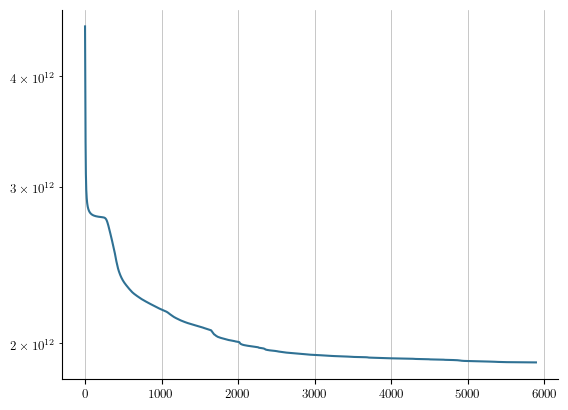

In [525]:
plt.plot(np.arange(len(loss_ts)), loss_ts)
plt.yscale('log')

In [526]:
# Get predictions for each year
predicted_transport_plans = xr.DataArray(
    torch.stack([
    NN(torch.concat([training_data[i], topology[i].flatten()])).reshape(N, N).detach() * topology[i] for i in range(len(training_data))
]), dims=["year", "source", "destination"],
    coords={"year": UN_data.sel({'year': YEAR_SEL}).coords["year"].data,
            "source": UN_data.coords["country"].data, 
            "destination": UN_data.coords["country"].data}
)

# Get the predicted net migration for each year
predicted_net_migration = (predicted_transport_plans.sum("source").rename({"destination": "source"}) - predicted_transport_plans.sum("destination")).rename({"source": "country"})

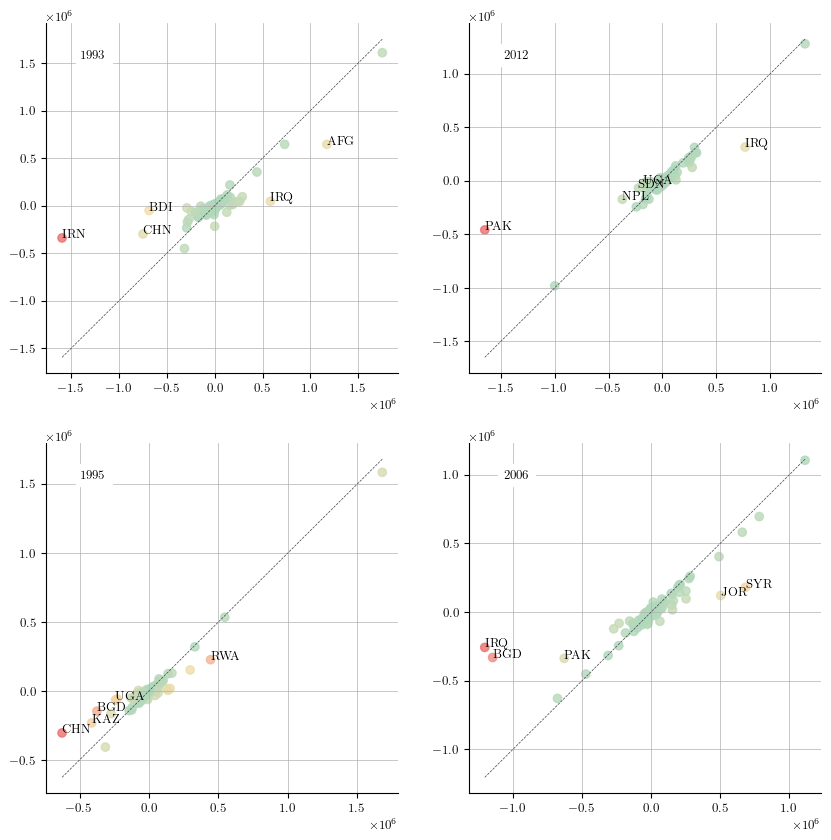

In [527]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

indices = np.random.choice(len(training_data), 4, replace=False)

for i, idx in enumerate(indices):
    color_data = abs((training_data[idx]-predicted_net_migration[idx]))
    cm = ColorManager(
    cmap={'from_values': {0: colors['c_lightgreen'], 0.5: colors['c_yellow'], 1: colors['c_red']}, 'continuous': True},
    vmin=color_data.min(), vmax=color_data.max())   
    axs.flatten()[i].scatter(training_data[idx], predicted_net_migration[idx], c=color_data, cmap=cm.cmap, alpha=0.8)
    _min = np.minimum(training_data[idx].numpy().min(), predicted_net_migration[idx].min().item())
    _max = np.maximum(training_data[idx].numpy().max(), predicted_net_migration[idx].max().item())
    axs.flatten()[i].plot(
        [_min, _max], [_min, _max], lw=0.5, color=colors['c_darkgrey'], linestyle='dashed'
    )
    axs.flatten()[i].text(0.1, 0.9, f"{UN_data.sel({'year': YEAR_SEL}).coords['year'].data[idx]}", transform=axs.flatten()[i].transAxes, backgroundcolor='white')
    
    # Label the 5 largest discrepancies
    max_discrepancies = color_data.isel({"country": color_data.argsort().data[-5:]})
    for country in max_discrepancies.coords['country'].data:
        axs.flatten()[i].text(UN_data['Net Number of Migrants (thousands)'].sel({"country": country, 'year': predicted_net_migration[idx].coords['year'].data}) * 1000, 
                              predicted_net_migration[idx].sel({"country": country}), country)
# fig.savefig("/Users/thomasgaskin/Prediction_errors_2.png", dpi=400)

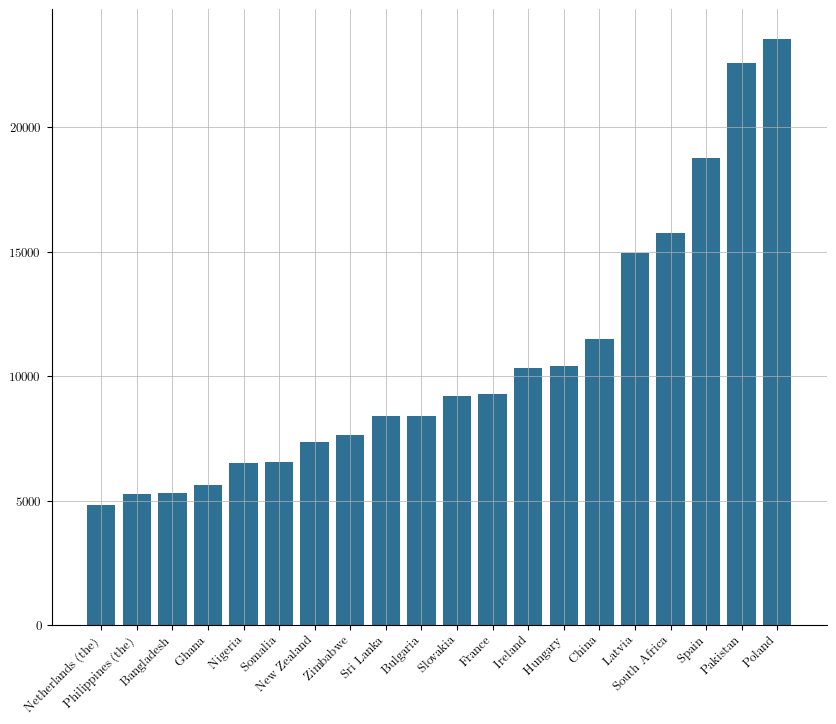

In [528]:
fig, ax = plt.subplots(figsize=(10, 8))
x, y = "destination", "source"
_ex = predicted_transport_plans.sel({"year": 2012, x: "GBR"}, drop=True)
_ex = _ex.isel({y: _ex.argsort().data[-20:]})
ax.bar(_ex.coords[y], _ex)
_ = ax.set_xticks(_ex.coords[y].data, [iso3_to_name.get(c, c) for c in _ex.coords[y].data], rotation=45, ha='right')

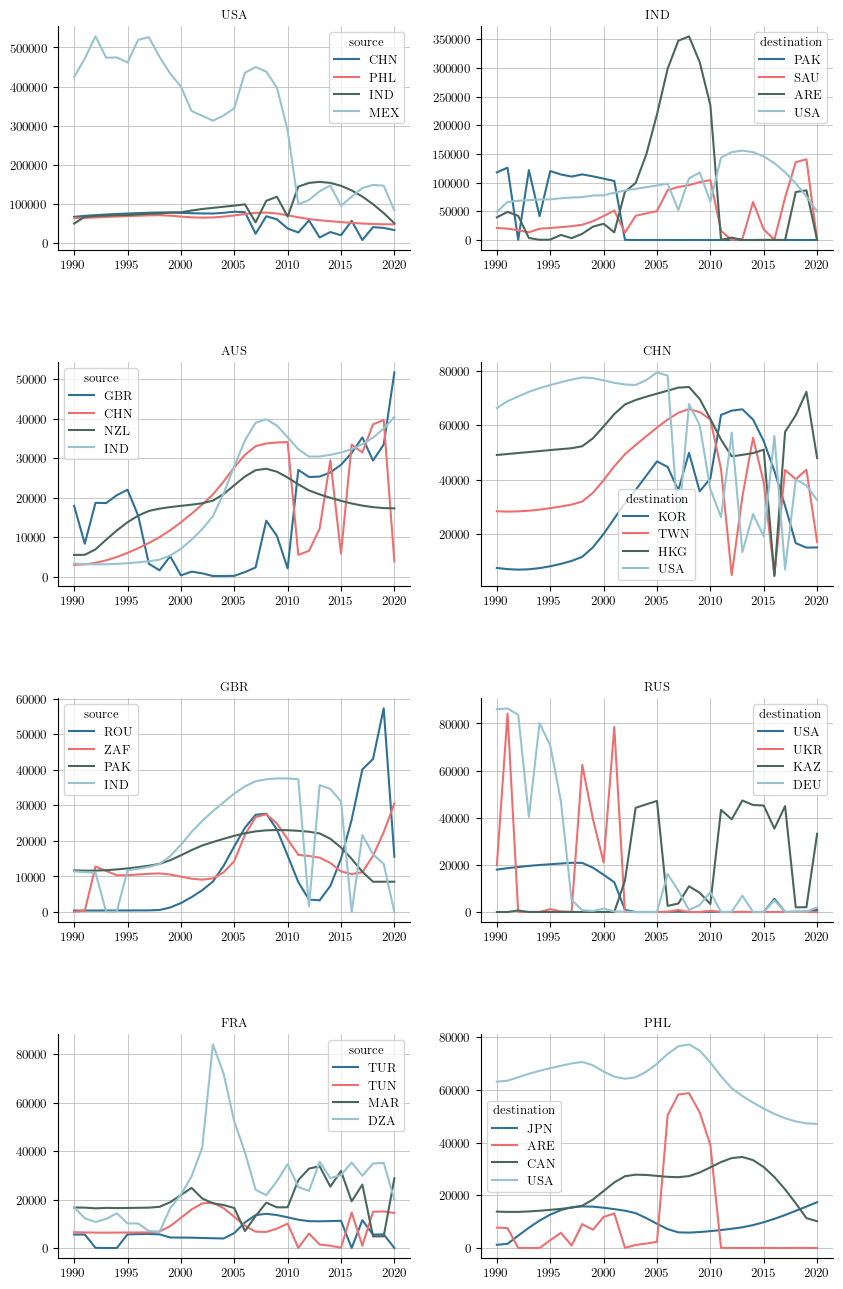

In [523]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 16))
fig.subplots_adjust(hspace=0.5)
for idx, country in enumerate(["USA", "AUS", "GBR", "FRA"]):
    ex_data = predicted_transport_plans.sel({"destination": country}, drop=True)
    ex_data = ex_data.isel({"source": ex_data.mean('year').argsort().data[-4:]})
    _ = ex_data.plot.line(hue="source", ax=axs[idx, 0])
    axs[idx, 0].set_title(country)
    axs[idx, 0].set_xlabel('')

for idx, country in enumerate(["IND", "CHN", "RUS", "PHL"]):
    ex_data = predicted_transport_plans.sel({"source": country}, drop=True)
    ex_data = ex_data.isel({"destination": ex_data.mean('year').argsort().data[-4:]})
    _ = ex_data.plot.line(hue="destination", ax=axs[idx, 1])
    axs[idx, 1].set_title(country)
    axs[idx, 1].set_xlabel('')

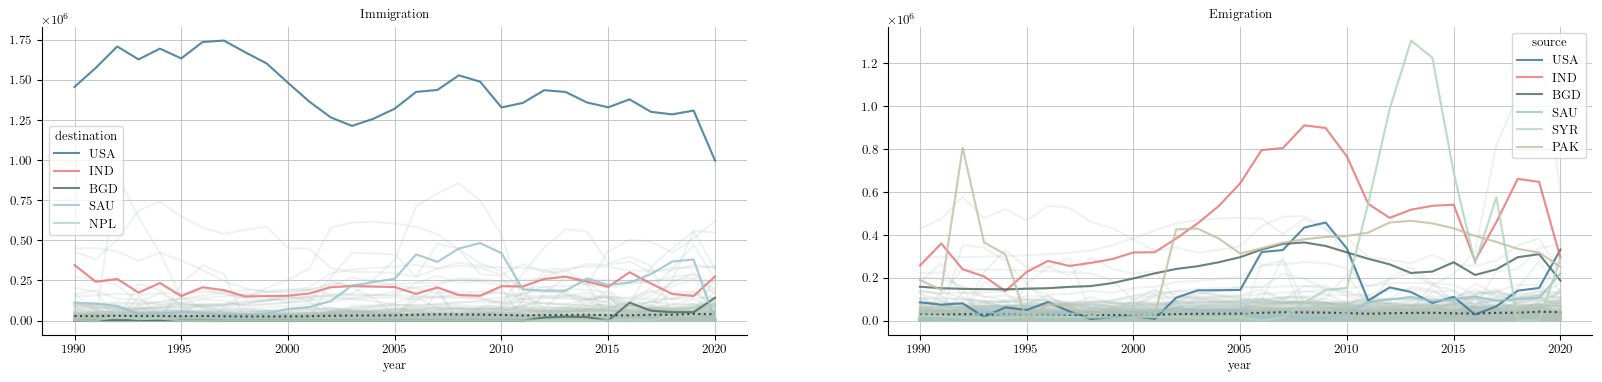

In [531]:
# Total volume of migration flow
fig, axs = plt.subplots(ncols=2, figsize=(20, 4))
_ = predicted_transport_plans.sum(['source']).plot.line(hue='destination', 
                                                    ax=axs[0], add_legend=False,
                                                    color=colors['c_lightgrey'], alpha=0.2)
_ = predicted_transport_plans.sum(['source']).sel({'destination': ["USA", "IND", "BGD", "SAU", "NPL"]}).plot.line(ax=axs[0], add_legend=True,hue='destination', alpha=0.8)
_ = predicted_transport_plans.sum(['source']).mean('destination').plot.line(ax=axs[0], color=colors['c_darkgrey'], add_legend=True, label="Mean", linestyle='dotted')
axs[0].set_title("Immigration")

_ = predicted_transport_plans.sum(['destination']).plot.line(hue='source', 
                                                    ax=axs[1], add_legend=False,
                                                    color=colors['c_lightgrey'], alpha=0.2)
_ = predicted_transport_plans.sum(['destination']).mean('source').plot.line(ax=axs[1], label="Mean", linestyle='dotted', color=colors['c_darkgrey'])
_ = predicted_transport_plans.sum(['destination']).sel({'source': ["USA", "IND", "BGD", "SAU", "SYR", "PAK"]}).plot.line(ax=axs[1], add_legend=True,hue='source', alpha=0.8)
_ =axs[1].set_title("Emigration")

In [532]:
# Plot the predicted flow of migrants for a given year

nw = nx.DiGraph()

year = 2018
pred = predicted_transport_plans.sel({"year": year}, drop=True)

# Add the exporters
for country in pred.coords['source'].data:

    nw.add_node(country, pos=(country_coords.loc[country, 'Latitude'], 
                              country_coords.loc[country, 'Longitude']),
                net_migration=UN_data['Net Number of Migrants (thousands)'].sel({"year": year, "country": country}))

# Add edges
for source in pred.coords['source'].data:
    for dest in pred.coords['destination'].data:
        if source == dest:
            continue
        T = pred.sel({"source": source, "destination": dest})
        nw.add_edge(source, dest, weight=T.data.item())

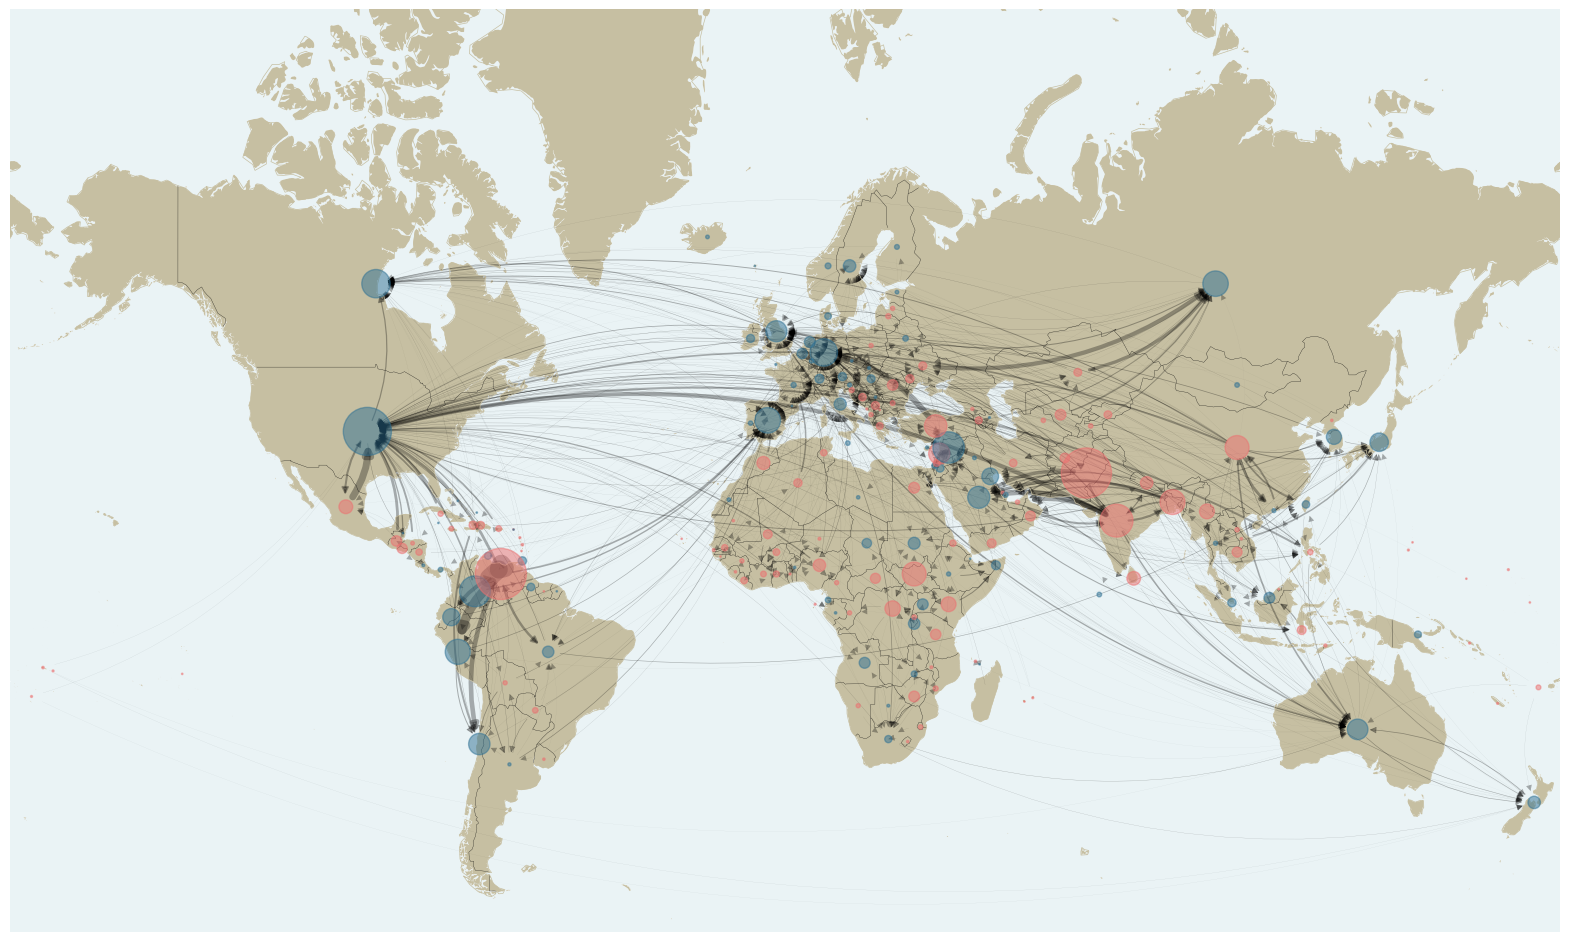

In [534]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(projection=ccrs.Mercator()))
ax.coastlines(color=colors['c_lightbrown'], lw=0.5)
land = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', facecolor=colors['c_lightbrown'])
sea = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=colors['c_lightblue'], alpha=0.2)
ax.axis('off')
ax.set_extent([-180, 180, -60, 80])
ax.add_feature(land, zorder=-2)
ax.add_feature(sea, zorder=-3)
ax.add_feature(BORDERS, lw=0.2, zorder=-1)
 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Plot the nodes
node_pos = dict((k, transformer.transform(*v)) for k, v in nx.get_node_attributes(nw, 'pos').items())
node_size = dict((k, abs(v)) for k, v in nx.get_node_attributes(nw, 'net_migration').items())
node_colors = [colors['c_red'] if v < 1 else colors['c_darkblue'] for v in nx.get_node_attributes(nw, 'net_migration').values()]
nx.draw_networkx_nodes(nw, node_pos, ax=ax, node_size=list(node_size.values()), node_color=node_colors, alpha=0.5)

# Plot the n largest flows
n = 1000
edges = dict(((u[0], u[1]), u[2]) for u in sorted([(k[0], k[1], v) for k, v in nx.get_edge_attributes(nw, 'weight').items()], key=lambda l: l[-1], reverse=True)[:n])

_ = nx.draw_networkx_edges(nw, node_pos, edges, ax=ax, alpha=0.3, 
                           width=3e-5*np.array(list(edges.values())),
                           connectionstyle='arc3, rad=0.2', arrowsize=10)

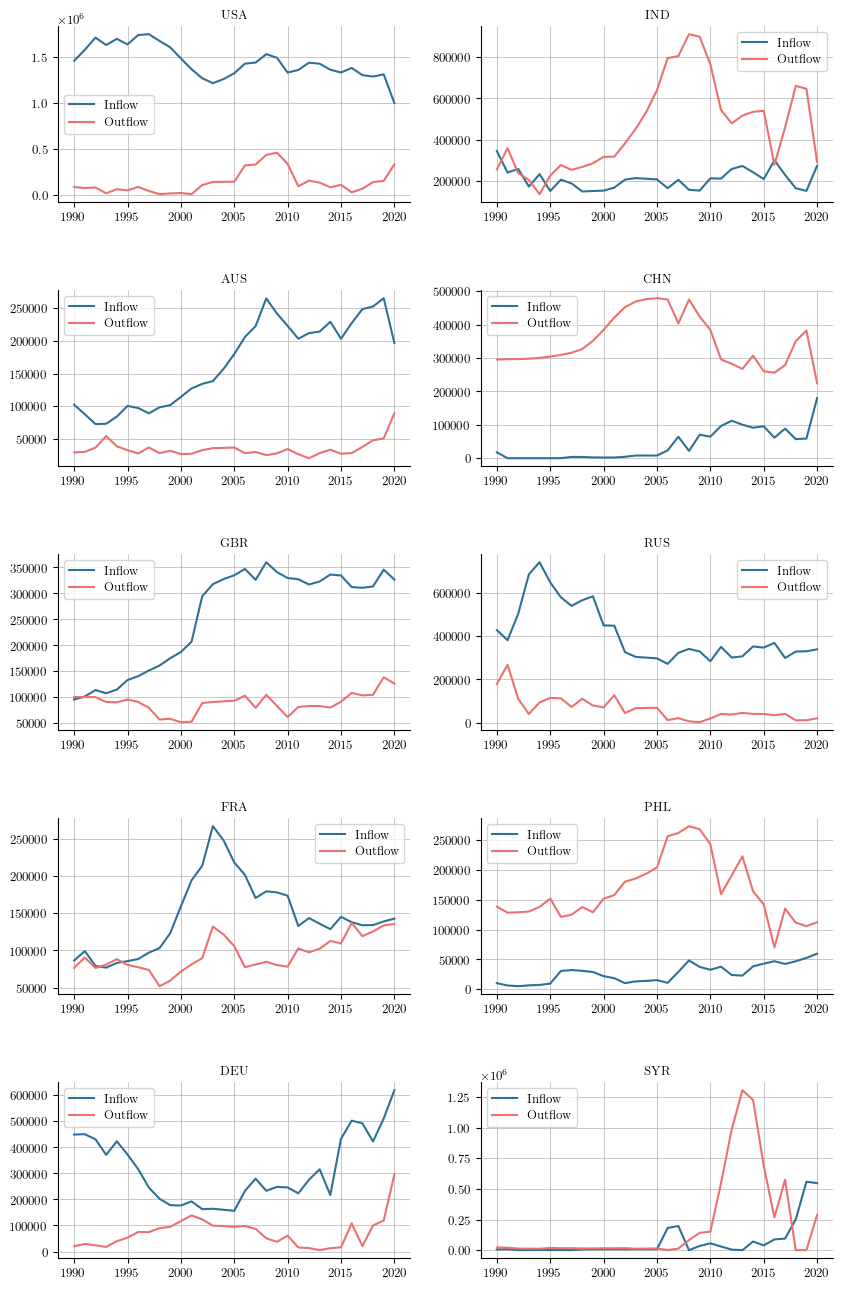

In [540]:
# Total outflows 
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 16))
fig.subplots_adjust(hspace=0.5)
for idx, country in enumerate(["USA", "AUS", "GBR", "FRA", 'DEU']):
    inflow = predicted_transport_plans.sel({"destination": country}, drop=True).sum("source")
    outflow = predicted_transport_plans.sel({"source": country}, drop=True).sum("destination")
    inflow.plot.line(ax=axs[idx, 0], label='Inflow')
    outflow.plot.line(ax=axs[idx, 0], label='Outflow')
    axs[idx, 0].set_title(country)
    axs[idx, 0].set_xlabel('')
    axs[idx, 0].legend()

for idx, country in enumerate(["IND", "CHN", "RUS", "PHL", "SYR"]):
    inflow = predicted_transport_plans.sel({"destination": country}, drop=True).sum("source")
    outflow = predicted_transport_plans.sel({"source": country}, drop=True).sum("destination")
    inflow.plot.line(ax=axs[idx, 1], label='Inflow')
    outflow.plot.line(ax=axs[idx, 1], label='Outflow')
    axs[idx, 1].set_title(country)
    axs[idx, 1].set_xlabel('')
    axs[idx, 1].legend()